In [ ]:
%pylab inline

import numpy as np
import tensorflow as tf

import scipy
from scipy import integrate
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Input,Dense,Convolution1D,Activation, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from IPython.display import clear_output

In [ ]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.yscale('log')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()


In [3]:
def progress_bar(percent):
    length = 40
    pos = round(length*percent)
    clear_output(wait=True)
    print('['+'█'*pos+' '*(length-pos)+']  '+str(int(100*percent))+'%')

## Load RD trajectories
Trajectories have been generated in MATLAB for randomly generated initial conditions.

In [4]:
num_train = 20
num_tests = 1
look_back = 20

N = 128
T = 201
num_iter = num_tests + num_train
RD_all_data = np.zeros((num_train,T,N,2*N))
#RD_input_data = np.zeros(((T-look_back)*(num_train), look_back, N, 2*N))
#RD_target_data = np.zeros(((T-look_back)*(num_train),N,2*N))

for i in range(num_train):
    d = loadmat('PDECODES/RD_data/N'+str(N)+'/iter'+str(i+1)+'.mat')
    u = d['u']
    v = d['v'] 
    RD_all_data[i,:,:,:N] = u[:,:,:].T # u(x,y,t) -> (t,y,x)
    RD_all_data[i,:,:,N:] = v[:,:,:].T
#    for l in range(look_back):
#        RD_input_data[i*(T-look_back):(i+1)*(T-look_back),l] = RD_all_data[i,l:-(look_back-l)] #(t,y,x)
#    RD_target_data[i*(T-look_back):(i+1)*(T-look_back),:,:] = RD_all_data[i,look_back:,:,:]

In [5]:
RD_test_data = np.zeros((T*num_tests,N,2*N))
for i in range(num_tests):
    d = loadmat('PDECODES/RD_data/N'+str(N)+'/iter'+str(num_iter-i)+'.mat')
    u = d['u']
    v = d['v']
    RD_test_data[i*T:(i+1)*T,:,:N] = u.T
    RD_test_data[i*T:(i+1)*T,:,N:] = v.T

In [ ]:
#model = Sequential()
#model.add(LSTM(2*N*N, activation="tanh", recurrent_activation="sigmoid"))
#model.add(Dense(N*N))

In [ ]:
# # Again use Adam
# adam_ = keras.optimizers.Adam(lr=.02, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=True, clipvalue=0.5)
# model.compile(loss='mean_squared_error', optimizer=adam_, metrics=['accuracy'])

In [ ]:
#mpl.rcParams['text.usetex'] = False
#model.fit(
#    np.reshape(RD_input_data,(RD_input_data.shape[0],RD_input_data.shape[1],N*2*N)), 
#    np.reshape(RD_target_data,(-1,N*2*N)), 
#    epochs=100, batch_size=800, shuffle=True, callbacks=[plot_losses], validation_split=0.0)

In [ ]:
#RD_NN_prediction = np.zeros(np.reshape(RD_test_data[0:T],(-1,N*2*N)).shape)
#RD_NN_prediction[0:look_back] = np.reshape(RD_test_data[0:look_back],(-1,N*2*N))
#for k in range(T-look_back):
#    RD_NN_prediction[k+look_back] = model.predict(np.array([RD_NN_prediction[k:k+look_back]]))

## Compute SVD
Training on full data took too long because the data dimension is high, so train on reduced data instead. 
Reshape data and compute rank k approximation to find fixed subspace to which we project our spatial ponints at each time.

In [6]:
RD_all_data.shape #(num_train,T,N,2*N)

(20, 201, 128, 256)

In [7]:
RD_all_data_reshaped = np.reshape(RD_all_data[:,:,:,],(num_train*T,2*N*N)).T # A: (2*N*N, num_train*T)

In [8]:
np.shape(RD_all_data_reshaped)

(32768, 4020)

In [9]:
RD_all_data_reshaped = np.concatenate((RD_all_data_reshaped, np.reshape(RD_test_data[0:T],(-1,2*N*N)).T), axis=1)

In [10]:
# note in python, svd returns V.T
[uu,ss,vv] = scipy.linalg.svd(RD_all_data_reshaped,full_matrices=False)

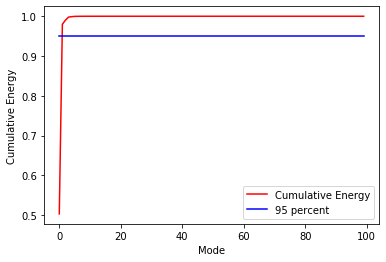

In [11]:
Ek=ss**2; 
Hk=Ek/np.sum(Ek); 
plt.plot(np.array(range(len(ss)))[0:100], np.cumsum(Hk[0:100]), 'r', label='Cumulative Energy')
plt.plot(np.array(range(len(ss)))[0:100], 0.95*np.ones_like(Hk[0:100]), 'b', label='95 percent')
plt.xlabel('Mode')
plt.ylabel('Cumulative Energy')
plt.legend()

In [12]:
# Get reduced SVD 
rank = 100
u_ = uu[:,:rank]
sig = ss[:rank]
v_ = vv[:rank]  #(rank, num_train*T)

In [13]:
SVD_all_data = np.reshape(v_, (rank, num_iter, T)) 
SVD_input_data = np.zeros(((T-look_back)*(num_train), look_back, rank))
SVD_target_data = np.zeros(((T-look_back)*(num_train),rank))

for i in range(num_train):
    for l in range(look_back):
        SVD_input_data[i*(T-look_back):(i+1)*(T-look_back),l,:] = SVD_all_data[:,i,l:-(look_back-l)].T
    SVD_target_data[i*(T-look_back):(i+1)*(T-look_back),:] = SVD_all_data[:,i,look_back:].T 

## Train Net on SVD data

In [14]:
model = Sequential()
model.add(LSTM(rank, activation="tanh", recurrent_activation="sigmoid", dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(rank))

In [15]:
# Again use Adam
adam_ = keras.optimizers.Adam(lr=.02, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=True, clipvalue=0.5)
model.compile(loss='mean_squared_error', optimizer=adam_, metrics=['accuracy'])

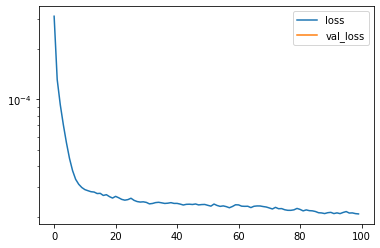

3620/3620 [==============================] - 1s 205us/step - loss: 2.0813e-05 - acc: 0.5373


In [16]:
mpl.rcParams['text.usetex'] = False
model.fit(
    SVD_input_data, 
    SVD_target_data,
    epochs=100, batch_size=500, shuffle=True, callbacks=[plot_losses], validation_split=0.0)

In [17]:
# Project test data on the PC space
SVD_test_data = np.dot(np.dot(np.reshape(RD_test_data[0:T],(-1,2*N*N)), u_), np.linalg.inv(np.diag(sig))) #(T,rank), A.T U 
#SVD_test_data = v_.T

In [18]:
SVD_NN_prediction = np.zeros(SVD_test_data.shape)
SVD_NN_prediction[0:look_back] = SVD_test_data[0:look_back]
for k in range(T-look_back):
    pred_input = np.reshape(SVD_NN_prediction[k:k+look_back], (look_back, rank))
    SVD_NN_prediction[k+look_back] = model.predict(np.array([pred_input]))

In [19]:
# Project back
RD_NN_prediction = np.dot(np.dot(SVD_NN_prediction, np.diag(sig)), u_.T)

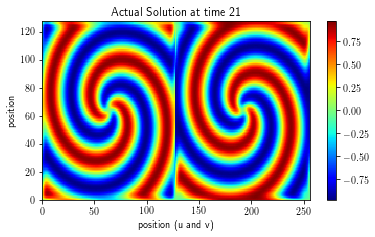

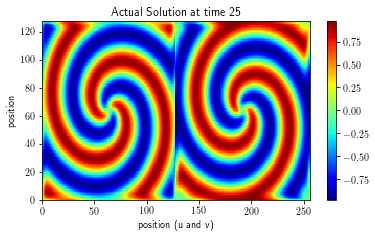

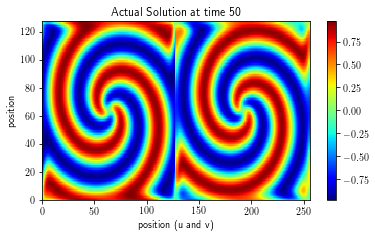

In [20]:
# Plot the test data at several sample times
tlist = [21, 25, 50]
for ii in range(len(tlist)):
    tt=tlist[ii]
    
    mpl.rcParams['text.usetex'] = True
    plt.figure(figsize=(6,3.3))
    m = plt.pcolor(np.reshape(RD_test_data[tt-1],(N,2*N)), cmap='jet')
    m.set_rasterized(True)
    plt.xlabel('position (u and v)')
    plt.ylabel('position')
    plt.colorbar()
    plt.title('Actual Solution at time ' + str(tt))
    

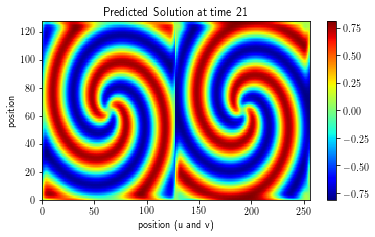

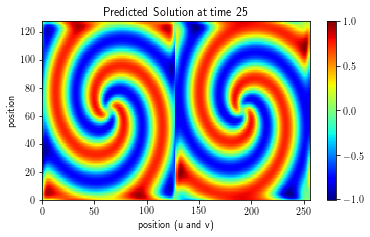

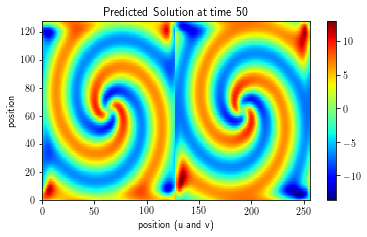

In [21]:
# plot the predicted test data at these sample times 
tlist = [21, 25, 50]
for ii in range(len(tlist)):
    tt=tlist[ii]

    mpl.rcParams['text.usetex'] = True
    plt.figure(figsize=(6,3.3))
    m = plt.pcolor(np.reshape(RD_NN_prediction[tt-1],(N,2*N)), cmap='jet')
    m.set_rasterized(True)
    plt.xlabel('position (u and v)')
    plt.ylabel('position')
    plt.colorbar()
    plt.title('Predicted Solution at time ' + str(tt))


Look at MSE in the high-D space

0.04824127211757698


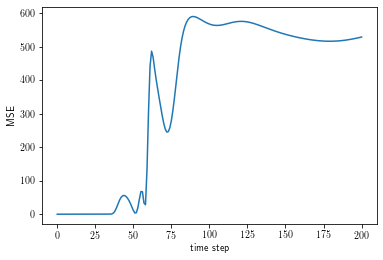

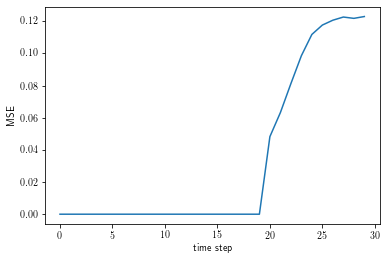

In [22]:
mse_total = ((np.reshape(RD_test_data, (-1,2*N*N))-RD_NN_prediction)**2).mean(axis=None)
mse_over_step = ((np.reshape(RD_test_data, (-1,2*N*N))-RD_NN_prediction)**2).mean(axis=-1)
mse_one_step = mse_over_step[look_back] - mse_over_step[look_back-1]

figure()
plt.plot(np.array(range(T)), mse_over_step)
xlabel('time step')
ylabel('MSE')

figure()
plt.plot(np.array(range(T)[0:30]), mse_over_step[0:30])
xlabel('time step')
ylabel('MSE')

print(mse_one_step)
# Training happens so much faster with SVD
# Even one-step MSE is high relative to the training error, there could still be overfitting

# One limitation: data generated by random phase offset of spiral, so they share similar structure 
# more work is needed to build a model that can generalize to wider set of initial conditions 

Look at MSE in the low-D space

0.00025897533038212237


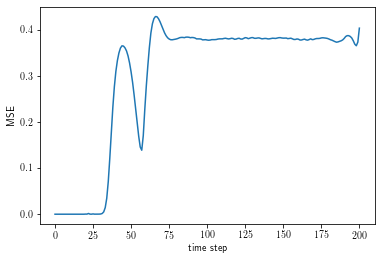

In [24]:
mse_total = ((SVD_test_data-SVD_NN_prediction)**2).mean(axis=None)
mse_over_step = ((SVD_test_data-SVD_NN_prediction)**2).mean(axis=-1)
mse_one_step = mse_over_step[look_back] - mse_over_step[look_back-1]

figure()
plt.plot(np.array(range(T)), mse_over_step)
xlabel('time step')
ylabel('MSE')

print(mse_one_step)